In [1]:
%cd /mnt/home/zzhang/ceph/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
from notebooks.runAmber_kinn import get_uniform_ms, get_finkelstein_ms, get_data
%matplotlib inline

Using TensorFlow backend.


0.1.1-ga


In [4]:
wd = "outputs/bak_20220208/CNN-wtCas9_cleave_rate_log-0-ppo/"
target = "wtCas9_cleave_rate_log"

res = get_data(target=target)
# unpack data tuple
x_train, y_train, x1, y1, x_test, y_test, x2, y2 = res

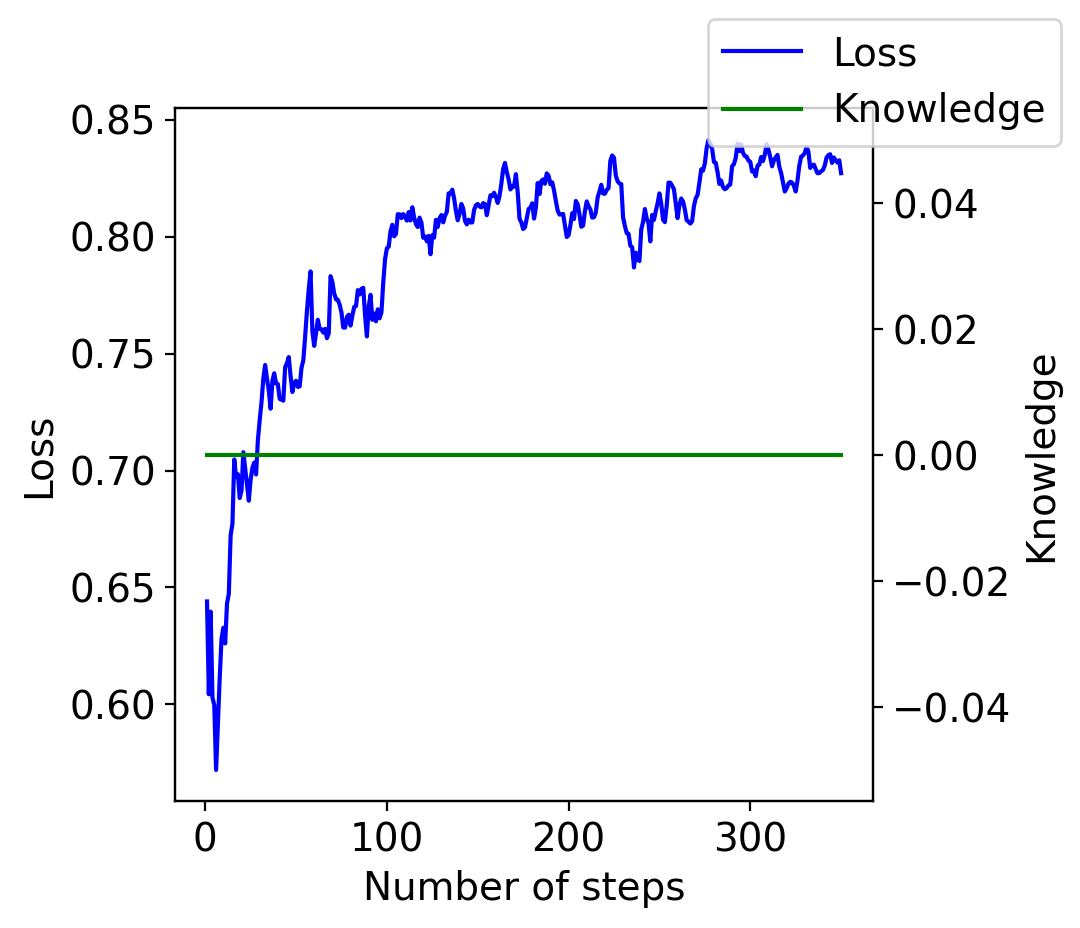

In [5]:
from IPython.display import Image

Image(filename=os.path.join(wd, "nas_training_stats.png"), width=400)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


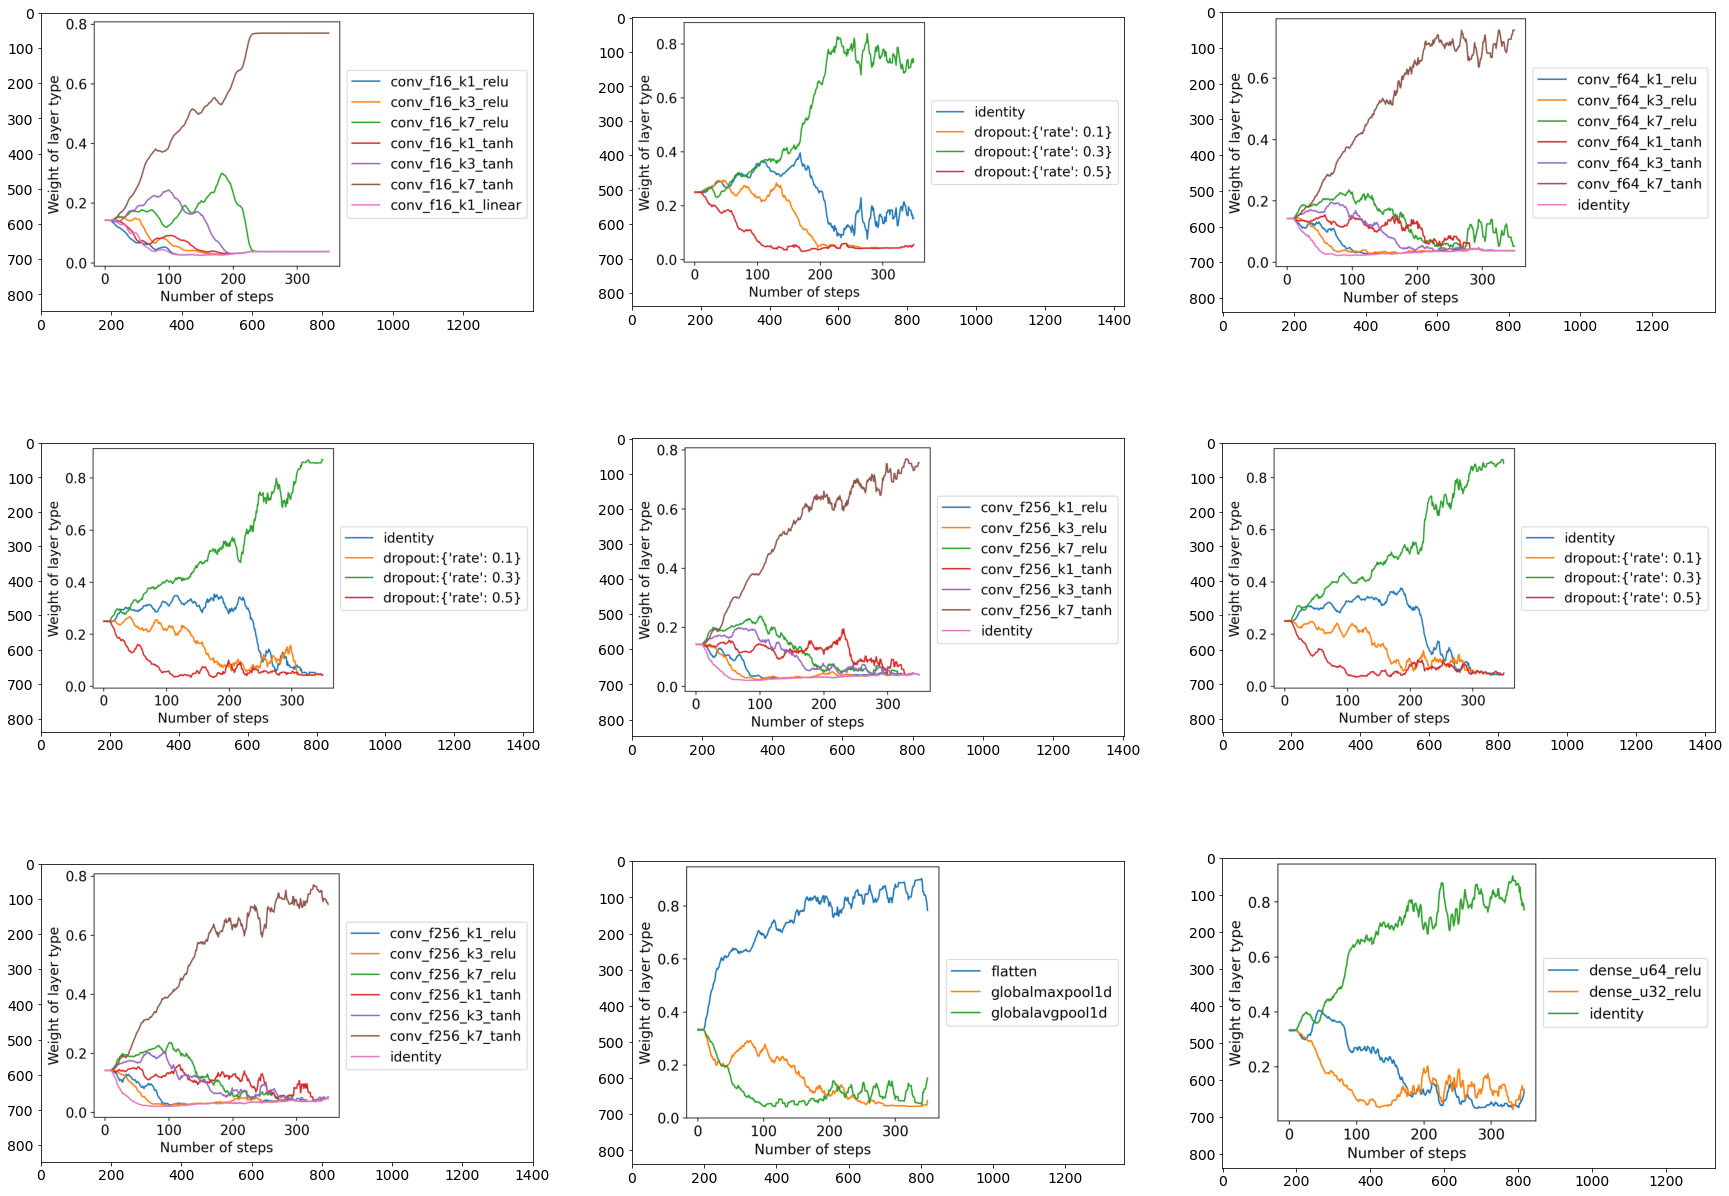

In [6]:
import matplotlib.image as mpimg

plt.figure(figsize=(30,30))
columns = 3
images = [mpimg.imread(os.path.join(wd,x)) for x in sorted([x for x in os.listdir(wd) if x.startswith("weight_at") and x.endswith("png")])]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [7]:
train_hist = pd.read_table(os.path.join(wd, "train_history.csv"), sep=",", header=None)
train_hist.sort_values(2, ascending=False)

,0,1,2,3,4,5,6,7,8,9,10,11
1462,1462,"[0, 0.8750966668437608]",0.875097,5,2,6,1,5,2,5,2,1
1563,1563,"[0, 0.8741880056936929]",0.874188,6,0,2,2,5,2,5,2,1
1242,1242,"[0, 0.8721353690471898]",0.872135,2,2,5,2,5,2,0,0,2
987,987,"[0, 0.8718249701839156]",0.871825,3,0,5,2,5,2,5,2,1
778,778,"[0, 0.8715165516966388]",0.871517,5,0,3,2,5,0,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
9,9,"[0, 0.24788125028029534]",0.247881,0,0,3,1,6,3,1,1,1
1147,1147,"[0, 0.22250121064327572]",0.222501,6,2,2,1,3,2,0,1,2
28,28,"[0, 0.17719569352014253]",0.177196,4,3,3,2,4,0,6,1,0
106,106,"[0, 0.10760199667834021]",0.107602,3,1,0,2,0,2,3,1,2


In [8]:
best_trial_id = train_hist.sort_values(2, ascending=False).head(1)[0]
model = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 25, 9)]           0         
_________________________________________________________________
conv0 (Conv1D)               (None, 19, 16)            1024      
_________________________________________________________________
dropout (Dropout)            (None, 19, 16)            0         
_________________________________________________________________
id1 (Lambda)                 (None, 19, 16)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 16)            0         
_________________________________________________________________
conv2 (Conv1D)               (None, 13, 256)           28928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 256)           0     

In [10]:
model.compile(loss="mse", optimizer="adam")

spearman SpearmanrResult(correlation=0.7865532316902623, pvalue=0.0)
pearson (0.8753359884618419, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.875')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


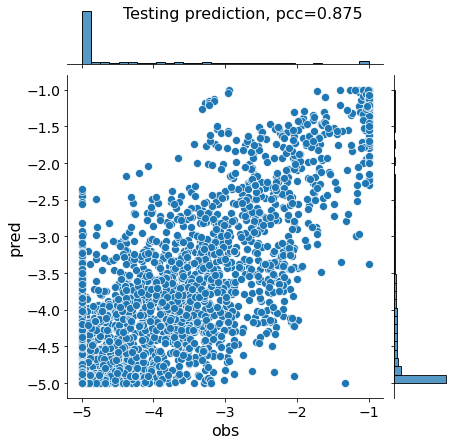

In [11]:
y_hat = model.predict(x_test).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p_old = ss.pearsonr(y_hat, y_test)
print("pearson", p_old)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p_old[0], fontsize=16)

In [12]:
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                       save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=20,
    verbose=0)

hist = model.fit(x_train,
          y_train,
          batch_size=32,
          callbacks=[checkpointer, earlystopper],
          validation_data=(x_test, y_test),
          epochs=500,
          verbose=2)
model.load_weights('bestmodel.h5')

Train on 6289 samples, validate on 5604 samples
Epoch 1/500
6289/6289 - 2s - loss: 0.3089 - val_loss: 0.3915
Epoch 2/500
6289/6289 - 2s - loss: 0.2906 - val_loss: 0.3594
Epoch 3/500
6289/6289 - 2s - loss: 0.2646 - val_loss: 0.3330
Epoch 4/500
6289/6289 - 2s - loss: 0.2592 - val_loss: 0.3843
Epoch 5/500
6289/6289 - 2s - loss: 0.2637 - val_loss: 0.3292
Epoch 6/500
6289/6289 - 2s - loss: 0.2566 - val_loss: 0.3533
Epoch 7/500
6289/6289 - 2s - loss: 0.2511 - val_loss: 0.3399
Epoch 8/500
6289/6289 - 2s - loss: 0.2396 - val_loss: 0.3241
Epoch 9/500
6289/6289 - 2s - loss: 0.2387 - val_loss: 0.3119
Epoch 10/500
6289/6289 - 2s - loss: 0.2256 - val_loss: 0.3247
Epoch 11/500
6289/6289 - 2s - loss: 0.2226 - val_loss: 0.3798
Epoch 12/500
6289/6289 - 2s - loss: 0.2109 - val_loss: 0.4279
Epoch 13/500
6289/6289 - 2s - loss: 0.2072 - val_loss: 0.3914
Epoch 14/500
6289/6289 - 2s - loss: 0.2081 - val_loss: 0.3549
Epoch 15/500
6289/6289 - 2s - loss: 0.2081 - val_loss: 0.3463
Epoch 16/500
6289/6289 - 2s - l

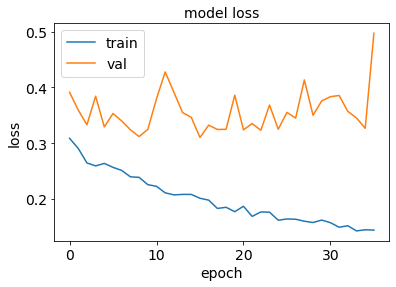

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

spearman SpearmanrResult(correlation=0.7705683738536362, pvalue=0.0)
pearson (0.867701406701849, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.868')

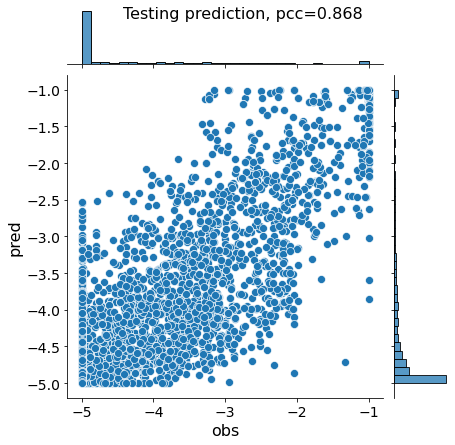

In [14]:
y_hat = model.predict(x_test).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test, y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test))
p = ss.pearsonr(y_hat, y_test)
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

In [15]:
if p_old[0] >= p[0]:
    model = tf.keras.models.load_model(os.path.join(wd, "weights", "trial_%i"%best_trial_id, "bestmodel.h5"))
    print("retraining is overfitting; load from amber search")
else:
    print("retraining improves the model")

retraining is overfitting; load from amber search


spearman SpearmanrResult(correlation=0.844274366663264, pvalue=0.0)
pearson (0.93600050017584, 0.0)


Text(0.5, 0.98, 'Train fit, pcc=0.936')

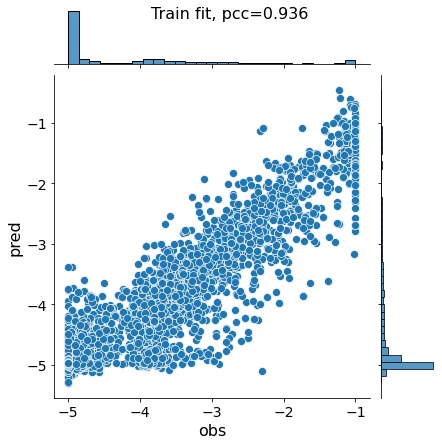

In [16]:
y_fit = model.predict(x_train).flatten()
h = sns.jointplot(y_train, y_fit)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_fit, y_train))
p = ss.pearsonr(y_fit, y_train)
print("pearson", p)
h.fig.suptitle("Train fit, pcc=%.3f"%p[0], fontsize=16)

spearman SpearmanrResult(correlation=0.7762658020570123, pvalue=1.2804037631671144e-282)
pearson (0.8690965003666886, 0.0)


Text(0.5, 0.98, 'sgRNA 2 - Test prediction, pcc=0.869')

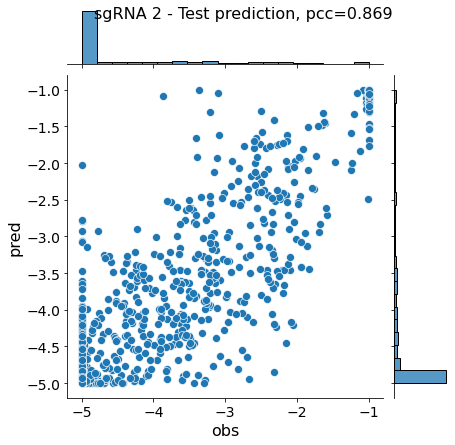

In [17]:
y_val_hat = model.predict(x2).flatten()
y_val_hat = np.clip(y_val_hat, -5, -1)

h = sns.jointplot(y2, y_val_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_val_hat, y2))
p = ss.pearsonr(y_val_hat, y2)
print("pearson", p)
h.fig.suptitle("sgRNA 2 - Test prediction, pcc=%.3f"%p[0], fontsize=16)

spearman SpearmanrResult(correlation=0.8554089346726381, pvalue=2.5602382105734515e-201)
pearson (0.9181133192224061, 2.2576658447666298e-282)


Text(0.5, 0.98, 'sgRNA 1 - Test prediction, pcc=0.918')

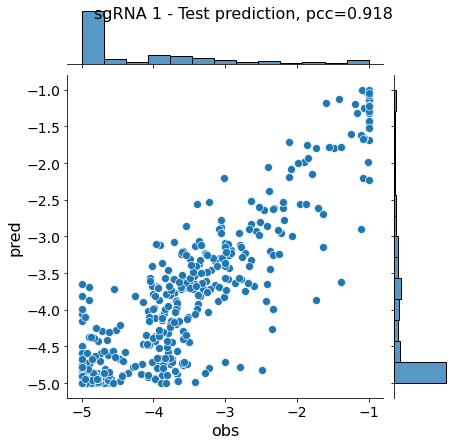

In [18]:
y_hat2 = model.predict(x1).flatten()
y_hat2 = np.clip(y_hat2, -5, -1)

h = sns.jointplot(y1, y_hat2)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat2, y1))
p = ss.pearsonr(y_hat2, y1)
print("pearson", p)
h.fig.suptitle("sgRNA 1 - Test prediction, pcc=%.3f"%p[0], fontsize=16)